# Deep KNN method

This notebook aims at evaluating the **DKNN method**.

The method consists in performing K-Nearest-Neighbors in the feature space of a neural
network trained on the in-distribution dataset.

Here, we focus on a toy convolutional network trained on MNIST[0-4] and a ResNet20 model
trained on CIFAR-10, respectively challenged on MNIST[5-9] and SVHN OOD datasets.

**Reference**
[Out-of-Distribution Detection with Deep Nearest Neighbors](http://arxiv.org/abs/2204.06507),
ICML 2022.


### Imports


In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from IPython.display import clear_output
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

from oodeel.methods import DKNN
from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets import OODDataset
from oodeel.utils.torch_training_tools import train_torch_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Note that models are saved at _~/.oodeel/saved_models_ and data is supposed to be found
at _~/.oodeel/datasets_ by default. Change the following cell for a custom path.


In [2]:
model_path = os.path.expanduser("~/") + ".oodeel/saved_models"
data_path = os.path.expanduser("~/") + ".oodeel/datasets"
os.makedirs(model_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

## First exp: MNIST[0-4] vs MNIST[5-9]

For this first experiment, we train a toy convolutional network on the MNIST dataset
restricted to digits 0 to 4. After fitting the train subset of this dataset to the DKNN
method, we will compare the scores returned for MNIST[0-4] (in-distrubtion) and
MNIST[5-9] (out-of-distribution) test subsets.


### Data loading

- In-distribution data: MNIST[0-4]
- Out-of-distribution data: MNIST[5-9]

> **Note:** We denote In-Distribution (ID) data with `_in` and Out-Of-Distribution (OOD)
> data with `_out` to avoid confusion with OOD detection which is the name of the task,
> and is therefore used to denote core classes such as `OODDataset` and `OODBaseDetector`.


In [3]:
# === load ID and OOD data ===
batch_size = 128
in_labels = [0, 1, 2, 3, 4]

# 1- load train/test MNIST dataset
mnist_train = OODDataset(
    dataset_id="MNIST",
    backend="torch",
    load_kwargs={"root": data_path, "train": True, "download": True},
)
mnist_test = OODDataset(
    dataset_id="MNIST",
    backend="torch",
    load_kwargs={"root": data_path, "train": False, "download": True},
)

# 2- split ID / OOD data depending on label value:
# in-distribution: MNIST[0-4] / out-of-distribution: MNIST[5-9]
oods_fit, _ = mnist_train.assign_ood_labels_by_class(in_labels=in_labels)
oods_in, oods_out = mnist_test.assign_ood_labels_by_class(in_labels=in_labels)


# 3- prepare data (preprocess, shuffle, batch) => torch dataloaders
def preprocess_fn(inputs):
    """Simple preprocessing function to normalize images in [0, 1]."""
    x = inputs[0] / 255.0
    return tuple([x] + list(inputs[1:]))


ds_fit = oods_fit.prepare(
    batch_size=batch_size, preprocess_fn=preprocess_fn, shuffle=True
)
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

clear_output()

### Model training

Now let's train a simple model on MNIST[0-4] using `train_torch_model` function.


In [4]:
# === Train / Load model ===
# model path
model_path_mnist_04 = os.path.join(model_path, "mnist_model_0-4")

try:
    # if the model exists, load it
    model = torch.load(os.path.join(model_path_mnist_04, "best.pt")).to(device)
except OSError:
    # else, train a new model
    train_config = {
        "model_name": "toy_convnet",
        "num_classes": 10,
        "epochs": 5,
        "save_dir": model_path_mnist_04,
        "validation_data": ds_in,
    }
    model = train_torch_model(ds_fit, **train_config).to(device)
    clear_output()

# evaluate model
model.eval()
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

Test accuracy:	0.995135


### DKNN score

We now fit a DKNN detector with MNIST[0-4] train dataset, and compare OOD scores
returned for MNIST[0-4] (ID) and MNIST[5-9] (OOD) test datasets.


Extracting the dataset features...: 100%|██████████| 240/240 [00:02<00:00, 111.78it/s]


auroc      0.972173
fpr95tpr   0.105857


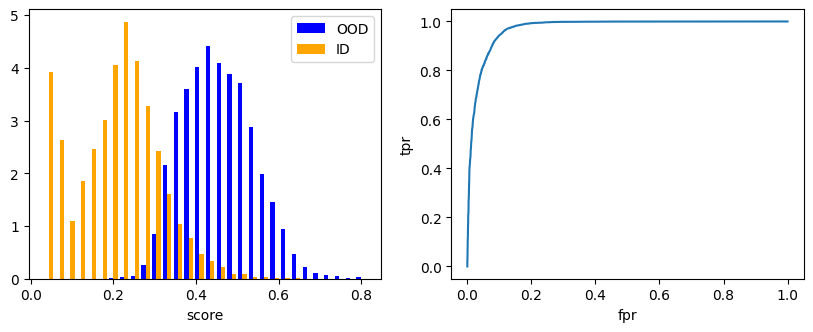

In [5]:
# === dknn scores ===
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_fit)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

# roc
fpr, tpr, _, _ = get_curve(
    scores=np.concatenate([scores_in, scores_out]),
    labels=np.concatenate([scores_in * 0 + 0, scores_out * 0 + 1]),
)

# plot hists / roc
plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.hist(
    x=(scores_out, scores_in),
    bins=30,
    color=("blue", "orange"),
    label=("OOD", "ID"),
    density=True,
)
plt.xlabel("score")
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()

## Second exp: CIFAR-10 vs SVHN

For this second experiment, we oppose **CIFAR-10** (in-distribution dataset) to **SVHN**
(out-of-distribution dataset).


### Data loading

- In-distribution data: CIFAR-10
- Out-of-distribution data: SVHN


In [6]:
# === load ID and OOD data ===
batch_size = 128

# 1a- load in-distribution dataset: CIFAR-10
oods_fit = OODDataset(
    dataset_id="CIFAR10",
    backend="torch",
    load_kwargs={"root": data_path, "train": True, "download": True},
)
oods_in = OODDataset(
    dataset_id="CIFAR10",
    backend="torch",
    load_kwargs={"root": data_path, "train": False, "download": True},
)
# 1b- load out-of-distribution dataset: SVHN
oods_out = OODDataset(
    dataset_id="SVHN",
    backend="torch",
    load_kwargs={"root": data_path, "split": "test", "download": True},
)


# 2- prepare data (preprocess, shuffle, batch) => torch dataloaders


def preprocess_fn(inputs):
    """Preprocessing function from
    https://github.com/chenyaofo/pytorch-cifar-models
    """
    x = inputs[0] / 255.0
    x = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))(x)
    return tuple([x] + list(inputs[1:]))


ds_fit = oods_fit.prepare(
    batch_size=batch_size, shuffle=True, preprocess_fn=preprocess_fn
)
ds_in = oods_in.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)
ds_out = oods_out.prepare(batch_size=batch_size, preprocess_fn=preprocess_fn)

clear_output()

### Model loading

The model is a **ResNet20** pretrained on CIFAR-10 and getting an accuracy score of
92.60%, loaded from
[pytorch-cifar-models](https://github.com/chenyaofo/pytorch-cifar-models) repository.


In [7]:
# === load model ===
# resnet20 pretrained on CIFAR-10
model = torch.hub.load(
    repo_or_dir="chenyaofo/pytorch-cifar-models",
    model="cifar10_resnet20",
    pretrained=True,
    verbose=False,
).to(device)
model.eval()

# evaluate model
labels, preds = [], []
for x, y in ds_in:
    x = x.to(device)
    preds.append(torch.argmax(model(x), dim=-1).detach().cpu())
    labels.append(y)
print(f"Test accuracy:\t{accuracy_score(torch.cat(labels), torch.cat(preds)):.6f}")

Test accuracy:	0.926000


### DKNN score

We now fit a DKNN detector with CIFAR-10 train dataset, and compare OOD scores returned
for CIFAR-10 (ID) and SVHN (OOD) test datasets.


Extracting the dataset features...: 100%|██████████| 391/391 [00:08<00:00, 47.13it/s]


auroc      0.919887
fpr95tpr   0.268600


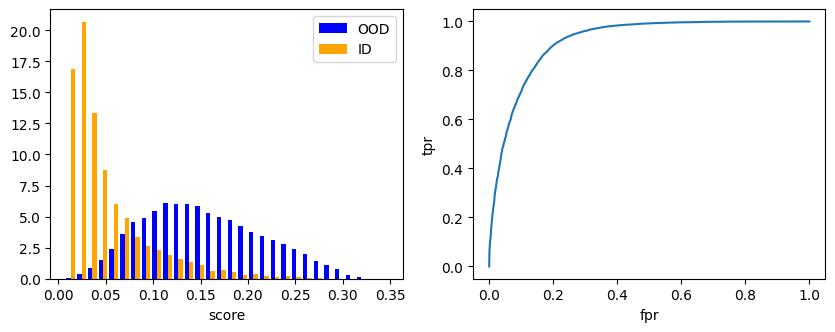

In [8]:
# === dknn scores ===
oodmodel = DKNN(nearest=50)
oodmodel.fit(model, ds_fit)
scores_in = oodmodel.score(ds_in)
scores_out = oodmodel.score(ds_out)

# === metrics ===
# auroc / fpr95
metrics = bench_metrics(
    (scores_in, scores_out),
    metrics=["auroc", "fpr95tpr"],
)
for k, v in metrics.items():
    print(f"{k:<10} {v:.6f}")

# roc
fpr, tpr, _, _ = get_curve(
    scores=np.concatenate([scores_in, scores_out]),
    labels=np.concatenate([scores_in * 0 + 0, scores_out * 0 + 1]),
)

# plot hists / roc
plt.figure(figsize=(10, 3.5))
plt.subplot(121)
plt.hist(
    x=(scores_out, scores_in),
    bins=30,
    color=("blue", "orange"),
    label=("OOD", "ID"),
    density=True,
)
plt.xlabel("score")
plt.legend()
plt.subplot(122)
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.show()